In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

plt.rcParams.update({'font.size': 10})

In [54]:
# Importation des données
df = pd.read_csv("data.csv", decimal = ",")
df.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


In [55]:
# Vérifier les types des colonnes
df.dtypes

Entreprise       object
Metier           object
Technologies     object
Diplome          object
Experience      float64
Ville            object
dtype: object

### 1) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes?

In [56]:
# Nombre d'observation du dataset
len(df)

9582

In [57]:
# Vérifier l'existence des valeurs manquantes
df.isnull().sum()

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64

Les colonnes Entreprise, Metier, Experience contiennent des valeurs manquantes

### 2) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec :

In [6]:
# a. la valeur médiane pour les data scientists
median_exp = df.loc[df.Metier == "Data scientist", 
                    "Experience"].median()

df.loc[df.Metier == "Data scientist", 
       "Experience"] = df.loc[df.Metier == "Data scientist", 
                              "Experience"].fillna(median_exp)

In [7]:
# b. la valeur moyenne pour les data engineers
mean_exp = df.loc[df.Metier == "Data engineer", 
                  "Experience"].mean()

df.loc[df.Metier == "Data engineer", 
       "Experience"] = df.loc[df.Metier == "Data engineer", 
                              "Experience"].fillna(mean_exp)

### 3) Combien d'années d'expériences ont, en moyenne, chacun des profils : ledata scientist, le lead data scientist et le data engineer en moyenne ?

In [8]:
df_mean_exp = df.loc[df.Metier.isin(["Lead data scientist",
                       "Data scientist",
                       "Data engineer"])].groupby("Metier").mean()

df_mean_exp

,Experience
Metier,
Data engineer,2.984959
Data scientist,2.241268
Lead data scientist,3.965261


### 4) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

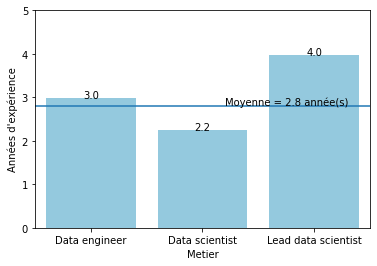

In [9]:
data = df_mean_exp.reset_index()
mean_ = df.Experience.mean()
ax = sns.barplot(x = data.iloc[:,0], 
                 y = data.iloc[:,1 ], 
                 data = data, color= "skyblue")
ax.set(ylabel= "Années d'expérience")
ax.axhline(mean_)
plt.ylim(0,5)
plt.text(1.2,
         mean_,
         'Moyenne = {:.1f} année(s)'.format(mean_),
         rotation=0)
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()
   ax.annotate('{:.1f}'.format(data.iloc[i,1]), 
               (x, y), ha='center')

 Les data scientists ont moins d'années d'expérience que les autres métiers data.

### 5)Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités : débutant, confirmé, avancé et expert. Veuillez expliquer votre choix de la règle de transformation.


Afin de discrétiser la variable "Experience", il existe deux approches :
- Approche statistique : Consiste à affecter chaque classe à un quartile. Par exemple : le dernier quartile correspond aux experts et le premier quartile correspond aux débutants.
- Approche métier : consiste à fixer des seuils pour chaque catégorie en se basant sur les connaissances métier du marché de travail Data.

Si on choisit l'approche statistique, c'est-à-dire affecter chaque classe à un quartile, cela reviendrait à dire que la proportion des débutants et des experts sont les mêmes sur le marché du travail data, ce qui n'est pas vrai dans la réalité. Aujourd'hui les débutants sont plus nombreux sur le marché de travail data à cause de l'explosion du nombre de formations data science, cependant, les experts sont plus rares.

Nous allons donc opter pour l'approche métier, car il est indépendant dans la distribution de l'expérience et se base des règles plus pertinentes définies par les experts métiers.

On va considérer :
- les débutants : Jeunes diplômés ayant moins 2 ans d'expérience
- Les confirmés : Personnes qui ont un validé une première longue expérience et commencent à aborder des sujets avancés, ils seront les personnes ayant entre 2 et 5 ans d'expérience
- Les avancés : personnes ayant une maitrise du domaine suite à plusieurs expériences de longues durées entre 5 ans et 10 ans
- Les experts : + 10 ans d'expérience

In [10]:
def discretize_exp(x):
    if x<2:
        return "debutant"
    elif x>=2 and x<5:
        return "confirmé"
    elif x>=5 and x<10:
        return "avancé"
    else :
        return "expert"
    
df["Exp_label"] = df.Experience.apply(discretize_exp)

### 6) Quelles sont les 5 technologies les plus utilisées ? Faites un graphique

In [68]:
# Les 5 groupes de technologies les plus utilisés
df.Technologies.value_counts().head()

SQL/R/Python//Big data                                539
SAS/Teradata/SQL/R/Python/Machine learning/Anglais    458
C++/R/Python/Matlab/Matplotlib                        273
SPSS/Excel/SAS/R/machine learning/AI/Scoring          250
Hadoop/Hive/Vertica/Tableau                           250
Name: Technologies, dtype: int64

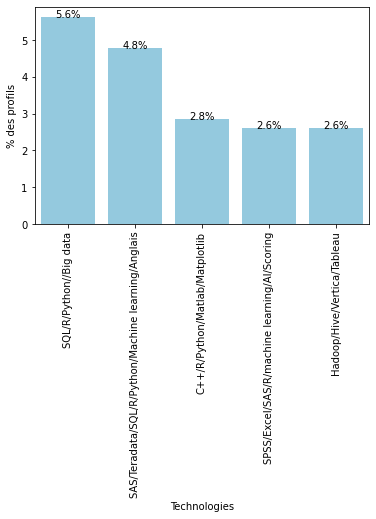

In [79]:
data = df.Technologies.value_counts(1).head().reset_index()
ax = sns.barplot(x = data.iloc[:,0], 
                 y = data.iloc[:,1] * 100, 
                 data = data, color= "skyblue")
ax.set(ylabel = "% des profils", xlabel= "Technologies")
plt.xticks(rotation=90)
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()
   ax.annotate('{:.1f}%'.format(data.iloc[i,1] * 100), 
               (x, y), ha='center')


In [12]:
# Les 5 technologies les plus utilisées 
df.Technologies.apply(lambda x : x.split("/")).explode().value_counts().head(5)

Python    6627
R         4374
SQL       2581
Java      1719
Hadoop    1589
Name: Technologies, dtype: int64

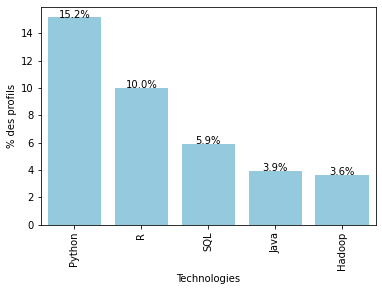

In [80]:
data = df.Technologies.apply(lambda x : x.split("/")).explode().value_counts(1).head(5).reset_index()
ax = sns.barplot(x = data.iloc[:,0], 
                 y = data.iloc[:,1] * 100, 
                 data = data, color= "skyblue")
ax.set(ylabel = "% des profils", xlabel= "Technologies")
plt.xticks(rotation=90)
patches = ax.patches
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()
   ax.annotate('{:.1f}%'.format(data.iloc[i,1] * 100), 
               (x, y), ha='center')


### 7) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître le nombre de clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.


#### Problématique

Les candidats à un emploi dans le domaine de la science des données peuvent être très hétérogènes car ils peuvent provenir de différentes formations (mathématiques, économie, informatique, physique, etc.), de différentes applications de la science des données (Computer Vision, BI, NLP, etc.) et de différents environnements technologiques (Python, R, SAS, SCALA, etc.).

Cette hétérogénéité rend plus difficile pour les équipes de ressources humaines de trouver la bonne personne pour le bon poste. Elles passent beaucoup de temps à trier les CV et à passer des entretiens avec les candidats avant de tomber sur le bon candidat.

Dans le but d'optimiser l'efficacité des équipes RH, nous allons donc proposer un clustering des profils DATA à partir de leurs diplômes, niveau d'expérience et les technologies qu'ils utilisent.

Cela permettra aux équipes de RH de cibler les bons candidats ou les profils qui conviennent au poste et regarder leurs CV en premier et ainsi réduire le temps et le coût de recrutement.

#### Méthodologie

KMeans utilise des mesures mathématiques (distance) pour regrouper des données continues. Plus la distance est faible, plus les points de données sont similaires. Les centroïdes sont mis à jour par les moyennes.
Cependant, pour les données catégorielles, nous ne pouvons pas calculer la distance euclidienne. Nous utilisons donc l'algorithme KModes. Il utilise les dissimilarités (total mismatches) entre les points de données. Plus les dissimilarités sont faibles, plus les points de données sont similaires. Il utilise les modes au lieu des moyennes.

In [13]:
df_c = df[["Diplome", 
           "Exp_label", 
           "Technologies",
           "Metier"]].dropna()
df_c.head()

,Diplome,Exp_label,Technologies,Metier
0,Master,debutant,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Data scientist
1,Master,confirmé,Python/Java/Scala/MongoDB,Data architecte
2,Master,confirmé,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Lead data scientist
3,Master,debutant,C/C++/Java/Python,Data scientist
4,Phd,confirmé,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Data scientist


#### a. Justifier le nombre de clusters

Pour KModes, on peut tracer le coût pour une plage de valeurs de K. Le coût est la somme de toutes les dissimilarités entre les clusters.

On choisit le K où on observe un coude avec une valeur de coût plus faible.

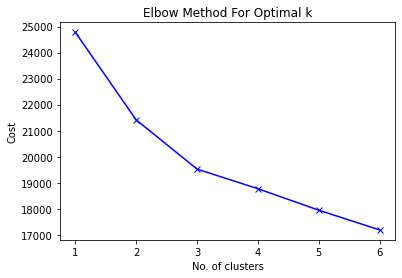

In [16]:
# Elbow curve to find optimal K
num_clusters = 7
cost = []
K = range(1,num_clusters)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters)
    kmode.fit_predict(df_c)
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

Nous pouvons voir un coude à K=3 dans le graphique ci-dessus indiquant que 3 est le nombre optimal de clusters.

In [17]:
kmode = KModes(n_clusters=3)
df_c["clusters"] = kmode.fit_predict(df_c)

#### b. Justifier la performance de votre algorithme grâce à une métrique.

In [18]:
kmode.cost_

19526.0

Notre algorithme converge avec un coût de 19969

#### c. Interpréter votre résultat.

In [19]:
def plot_(ax, data, xlabel):
    fig = sns.barplot(ax = ax, x = data.iloc[:,0], y = data.iloc[:,1]* 100, color = "skyblue")
    fig.set(xlabel= xlabel, ylabel = "% de profils avec cette compétence")
    patches = fig.patches
    for i in range(len(patches)):
       x = patches[i].get_x() + patches[i].get_width()/2
       y = patches[i].get_height() + 0.1
       ax.annotate('{:.1f}%'.format(data.iloc[i,1]* 100), (x, y), ha='center')


def plot_cluster_analysis(cluster, df_c, title):
    
    data_technologies = df_c.loc[df_c.clusters == cluster].Technologies.apply(lambda x : x.split("/")).explode().value_counts(1).head(10).reset_index()
    data_diplome = df_c.loc[df_c.clusters == cluster].Diplome.value_counts(1).reset_index()
    data_experience = df_c.loc[df_c.clusters == cluster].Exp_label.value_counts(1).reset_index()
    data_metier = df_c.loc[df_c.clusters == cluster].Metier.value_counts(1).reset_index()

    fig, axs = plt.subplots(2, 2, figsize=(17, 8))
    plot_(axs[0,0], data_technologies, "Technologies")
    plot_(axs[0,1], data_diplome, "Diplomes")
    plot_(axs[1,0], data_experience, "Niveaux d'expérience")
    plot_(axs[1,1], data_metier, "Métiers")
    fig.suptitle(title)

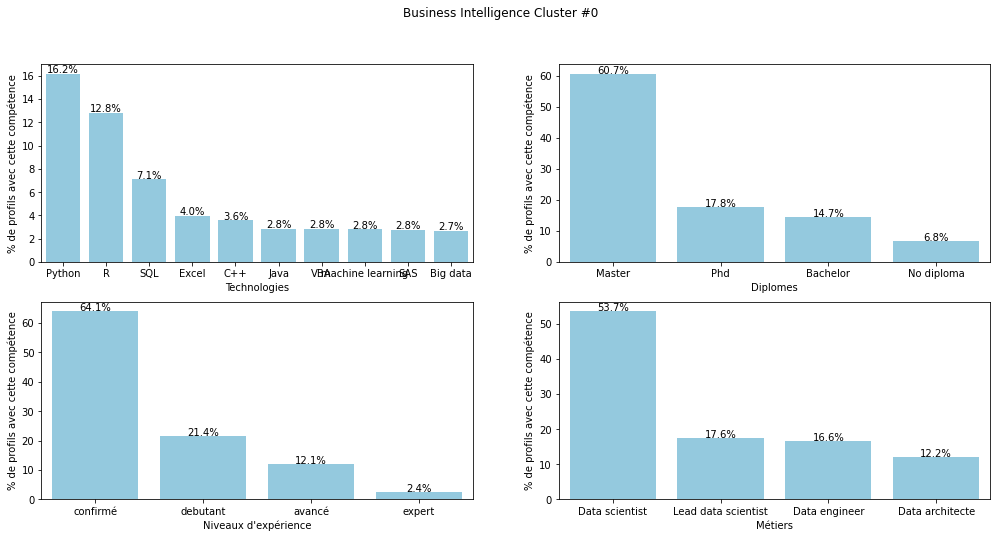

In [20]:
plot_cluster_analysis(0, df_c, "Business Intelligence Cluster #0")

Le cluster #0 est constitué avec des profils ayant de compétences relatives au BI (Python, R, SQL, Excel, VBA, SAS, ML) avec un niveau d'expérience intermédiaire (64% confirmés), sont principalement des data scientists 54% épaulés par des data engineers 17% et des data architecte 12%.

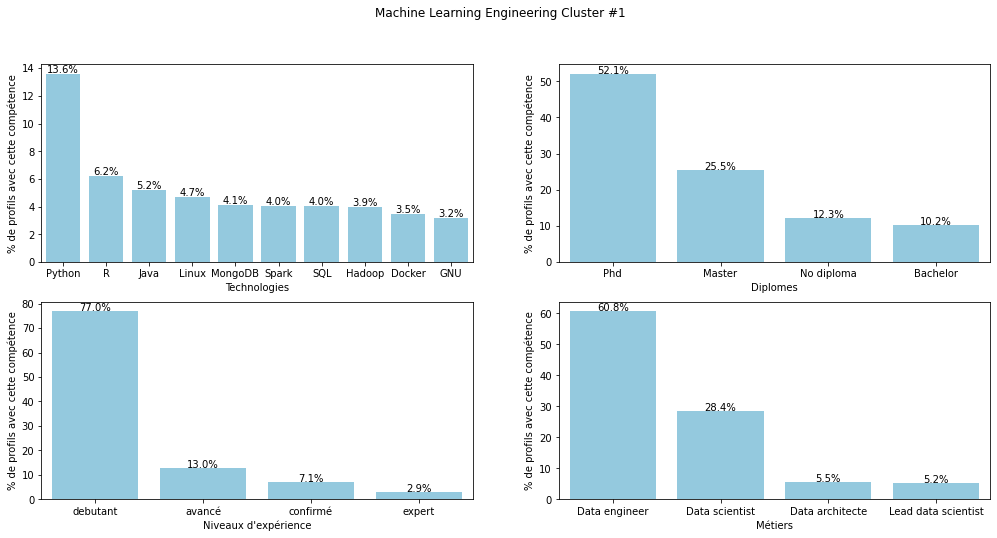

In [21]:
plot_cluster_analysis(1, df_c, "Machine Learning Engineering Cluster #1")

Le cluster #1 est constitué par des profils avec des connaissances théoriques avérées (52% Phd), des profils data avec des compétences en Big Data (Spark, Hadoop, MangoDB) avec une habilité de travailler avec Docker, Java et Linux. Ce cluster forme donc une équipe de Machine Learning Engineering capable d'un côté de travailler sur des sujets R&D (52% PHD) et de l'autre côté d'assurer leurs industrialisations (60% Data enginneers) grâce à leurs compétences en Big data, Docker, Linux et Java.

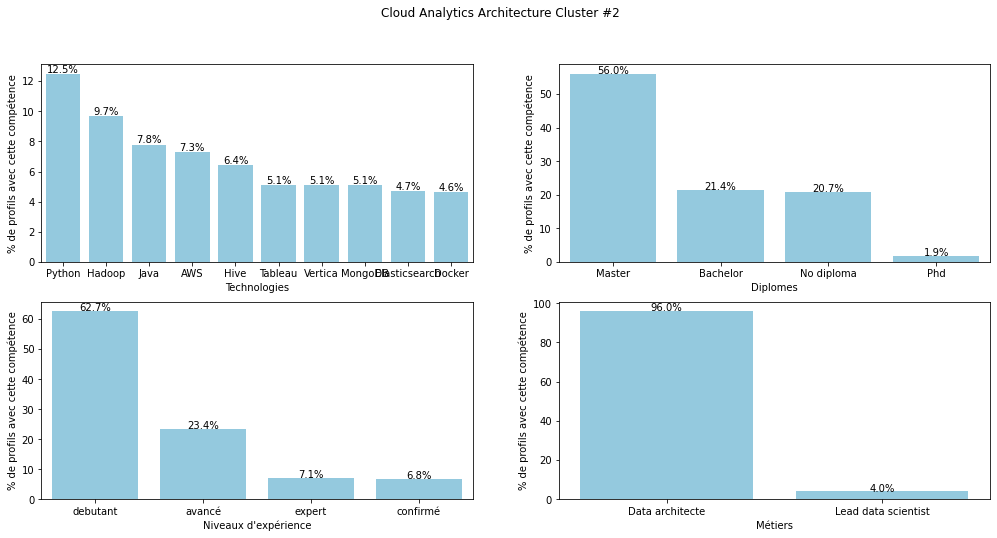

In [52]:
plot_cluster_analysis(2, df_c, "Cloud Analytics Architecture Cluster #2")

Le cluster #2 est formé par des profils data avec des compétences en Big Data et environnement cloud (Hadoop, Hive, AWS, etc.) et en même temps disposent des compétences dans les outils d'Analytics (Tableau et Vertica), sont principalement des data architecte épaulés par des lead Data scientist. Ce cluster peut former une équipe Cloud Analytics Architecture qui maîtrise les architectures clouds dans un contexte Analytics.

### 8) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix

In [34]:
features = ["Experience", "Technologies", "Diplome"]

X_temp = df.loc[~df.Metier.isnull() ,features]
y = df.loc[~df.Metier.isnull(), "Metier"]

# Fill nan with mean
mean_exp = X_temp.Experience.mean()
X_temp.Experience = X_temp.Experience.fillna(mean_exp)

# Encodage des variables catégorielles
encoder = OneHotEncoder(handle_unknown="ignore", sparse = False)
X_cat = encoder.fit_transform(X_temp[["Technologies", "Diplome"]])
df_cat = pd.DataFrame(X_cat, columns = encoder.get_feature_names())

# Concat Categorical and numerical features
X = pd.concat([df_cat.reset_index(drop = True), 
               X_temp["Experience"].reset_index(drop = True)], axis = 1)

# Split data on trainset and testset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [35]:
# train random forest classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [48]:
# Prediction des métiers manquants
X_predict_temp = df.loc[df.Metier.isnull() ,features]

# Fill nan with mean
X_predict_temp.Experience = X_predict_temp.Experience.fillna(mean_exp)

# Encode categorical data
X_predict_cat = encoder.transform(X_predict_temp[["Technologies", "Diplome"]])
df_cat_predict = pd.DataFrame(X_predict_cat, columns = encoder.get_feature_names())

# Concat Categorical and numerical features
X_predict = pd.concat([df_cat_predict.reset_index(drop = True), 
                       X_predict_temp["Experience"].reset_index(drop = True)], axis = 1)

# predict
df.loc[df.Metier.isnull() ,"Metier"] = clf.predict(X_predict)

#### a.Justifier la performance de votre algorithme grâce à une métri

In [49]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve

def evaluation(clf, X,y):
    X = X.copy()
    y = y.copy()
    y_pred = clf.predict(X)
    print(classification_report(y, y_pred))
    print("Normalized Confustion Matrix")
    print(pd.DataFrame(confusion_matrix(y, y_pred, normalize = "true")))

In [50]:
evaluation(clf, X_test, y_test)

                     precision    recall  f1-score   support

    Data architecte       0.98      0.97      0.98       683
      Data engineer       1.00      1.00      1.00       828
     Data scientist       0.83      0.88      0.86      1256
Lead data scientist       0.57      0.47      0.52       389

           accuracy                           0.88      3156
          macro avg       0.85      0.83      0.84      3156
       weighted avg       0.88      0.88      0.88      3156

Normalized Confustion Matrix
          0         1         2         3
0  0.972182  0.000000  0.026354  0.001464
1  0.000000  1.000000  0.000000  0.000000
2  0.007962  0.000796  0.883758  0.107484
3  0.007712  0.000000  0.519280  0.473008


In [51]:
clf.score(X_test, y_test)

0.8827629911280102

On predit les métiers manquants avec une accuracy de 88%

#### b. Interpréter votre résultat.

Notre algorithme distingue très bien entre les classes Data architecte, Data engineer et Data scientist avec une exactitude ente 1 et 0.8 et avec un taux de faux positif très faibles entre 11% et 0%. Cependant, il est moins performant sur la classe des Lead Data scientist, ces derniers, 50% des fois sont considérés comme des data scientists par l’algorithme. Cela est peut-être dû au fait qu'ils partagent les mêmes compétences que les data scientists.